# EP #3 - Geração de Mosaicos

Renato Sérgio Lopes Júnior \
2020667570


In [1]:
import os
import cv2
import numpy as np

# pip install opencv-contrib-python==4.4.0.44

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

## Read images

In [2]:
def read_images(path="imgs/"):
    imgs = []
    for img_name in ['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg', 'img5.jpg', 'img6.jpg']:
        img = cv2.imread(os.path.join(path, img_name))
        img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2), interpolation = cv2.INTER_AREA)
        imgs.append(img)
    return imgs

In [3]:
imgs = read_images()

## Define keypoint detection/description/matching methods

In [4]:
MAX_FEATURES = 1000

sift = cv2.SIFT_create(nfeatures=MAX_FEATURES)
fast = cv2.FastFeatureDetector_create(20)
orb = cv2.ORB_create(nfeatures=MAX_FEATURES)
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

def get_keypoints(img, alg):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if alg == 'sift':
        kp = sift.detect(gray, None)
    elif alg == 'fast':
        kp = fast.detect(gray, None)
    elif alg == 'orb':
        kp = orb.detect(img, None)
    else:
        raise ValueError('Invalid algorithm')
    return kp

def get_descriptor(img, kp, alg):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if alg == 'sift':
        kp, des = sift.compute(gray, kp)
    elif alg == 'brief':
        kp, des = brief.compute(img, kp)
    elif alg == 'orb':
        kp, des = orb.compute(img, kp)
    else:
        raise ValueError('Invalid algorithm')
    return kp, des

def get_matches(desc1, desc2, alg):
    if alg == 'brief' or alg == 'orb':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(desc1, desc2)
    elif alg == 'sift':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(desc1, desc2)
    else:
        raise ValueError('Invalid algorithm')
    return matches

def get_pairs(kp0, kp1, matches):
    pairs_src, pairs_dst = [], []
    for m in matches:
        pairs_src.append(kp0[m.queryIdx].pt)
        pairs_dst.append(kp1[m.trainIdx].pt)
    pairs_src = np.float32(pairs_src).reshape(-1,1,2)
    pairs_dst = np.float32(pairs_dst).reshape(-1,1,2)
    return pairs_src, pairs_dst

## Computing Homography

In [5]:
def compute_homograpy(img0, img1, alg_detect, alg_descr):
    # Detect keypoints
    print(f"Detect {alg_detect} keypoints for img0...")
    kp0 = get_keypoints(img0, alg_detect)
    print(f"Detected {alg_detect} keypoints for img0.")
    print(f"Detect {alg_detect} keypoints for img1...")
    kp1 = get_keypoints(img1, alg_detect)
    print(f"Detected {alg_detect} keypoints for img1.")
    # Get keypoints descriptions
    kp0, desc0 = get_descriptor(img0, kp0, alg_descr)
    kp1, desc1 = get_descriptor(img1, kp1, alg_descr)
    # Get matches
    matches = get_matches(desc0, desc1, alg_descr)
    # Get pairs of correspondence
    pairs_src, pairs_dst = get_pairs(kp0, kp1, matches)
    # Compute Homography
    H, mask = cv2.findHomography(pairs_src, pairs_dst, cv2.RANSAC)
    return H, mask

def get_translation_offset(h1, w1, h2, w2, H):
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    return (xmin, ymin, xmax, ymax)

def warpPerspective(img1, img2, H):
    xmin, ymin, xmax, ymax = get_translation_offset(*img1.shape[:2], *img2.shape[:2], H)
    t = [-xmin, -ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:img1.shape[0]+t[1], t[0]:img1.shape[1]+t[0]] = img1
    return result

### Transforming Images

In [6]:
DETECTOR, DESCRIPTOR = 'sift', 'sift'

Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.


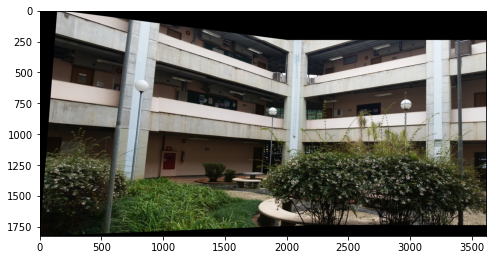

In [7]:
H, _ = compute_homograpy(imgs[0], imgs[1], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[1], imgs[0], H)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_res_left, cv2.COLOR_BGR2RGB))

Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.


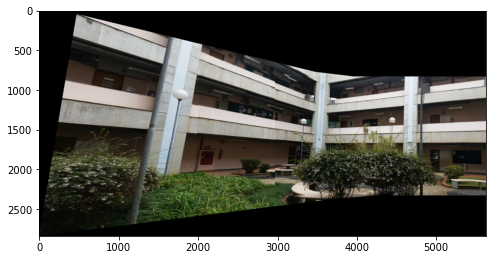

In [8]:
H, _ = compute_homograpy(img_res_left, imgs[2], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[2], img_res_left, H)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_res_left, cv2.COLOR_BGR2RGB))

Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.


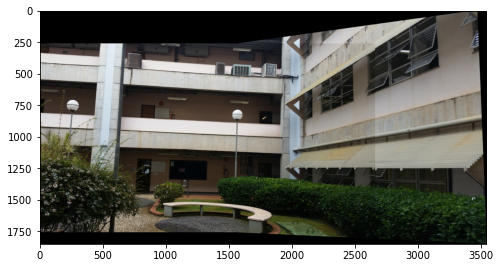

In [9]:
H, _ = compute_homograpy(imgs[5], imgs[4], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[4], imgs[5], H)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_res_right, cv2.COLOR_BGR2RGB))

Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.


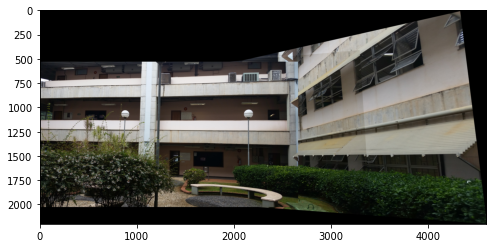

In [10]:
H, _ = compute_homograpy(img_res_right, imgs[3], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[3], img_res_right, H)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_res_right, cv2.COLOR_BGR2RGB))

Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.


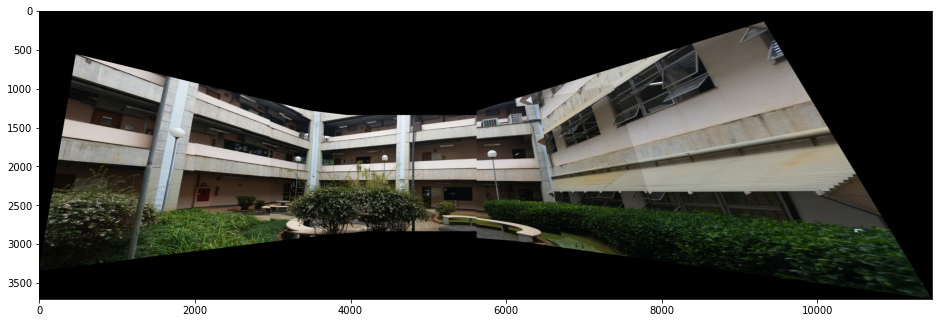

In [21]:
# H, _ = compute_homograpy(img_res_left, img_res_right, DETECTOR, DESCRIPTOR)
# img_res = warpPerspective(img_res_right, img_res_left, H)

H, _ = compute_homograpy(img_res_right, img_res_left, DETECTOR, DESCRIPTOR)
img_res = warpPerspective(img_res_left, img_res_right, H)

fig = plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))